# Lab. 6: Bayesian Optimization

## Introduction

#### <u>The goal of this lab is to study the behavior of Bayesian optimization on a regression problem.</u>

Bayesian optimization is a probabilistic approach that uses the Bayes' Theorem $P(A|B) = \frac{P(B|A)*P(A)}{P(B)}$. Briefly, we use the prior information, P(A),(random samples) to optimize a surrogate function, P(B|A).

[Here](https://scikit-learn.org/1.2/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor.predict) you can find the "Gaussian Process Regressor" class documentation.

You'll have to implement some methods:

- *Aquisition Functions*:
  - `USB(args)` Upper Confidence Bound
  $$ \mu(x) + k \sigma(x)  $$
  - `LSB(args)` Lower Confidence Bound (for minimization only)
  $$ \mu(x) - k \sigma(x)  $$
  - `PI(args)` Probability Improvement
  $$ P(f(x) + k \sigma(x))  $$
  namely
  $$ 1-\Phi(z_0) = \Phi(-z_0) = \Phi(-\frac{f(x^*) + k - \mu(x)}{\sigma(x)}) $$
  where $\Phi$ is the normal cumulative distribution function (hint: use [scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy-stats-norm)).
  - `EI(args)` Expected Improvement
  $$ EI(x) = E[f(x) - f(x_t^+)] $$
  namely
  $$ EI(x) = (\mu(x) - f(x^*) - k)\Phi(\frac{\mu(x) - f(x^*) - k}{\sigma(x)}) + \sigma(x)\varphi(\frac{f(x^*) + k - \mu(x)}{\sigma(x)}) $$
  where $\Phi$ is the normal cumulative distribution function and $\varphi$ is the probability density function (hint: use [scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy-stats-norm))

- *Prior Functions*:
  - `Prior_1(objective_fun, size)` Where `X` is a random array of size `size` and `Y` is the array of `f(x)`.
  - `Prior_2(objective_fun, size)` Where `X` is an array of size `size` of numbers sampled from a uniform distribution `[0.5, 1]` and `Y` is the array of `f(x)`.
  - `Prior_3(objective_fun, size)` Where `X` is an array of size `size` of numbers sampled from a uniform distribution `[0, 0.5]` and `Y` is the array of `f(x)`.
- *Optimization Functions*. Here you can find some examples, feel free to use different functions:
  - `multimodal_1(x)`
  $$ \sin(x) + \sin(\frac{10}{3}x) $$
  - `multimodal_2(x)`
  $$ (1.4-3.0x) \sin(18x) $$
  - `multimodal_3(x)`
  $$ x^2 + \sin(5 \pi x)^6 $$
---

In [26]:
%%capture
!pip install scikit-optimize

In [27]:
# example of bayesian optimization for a 1d function from scratch
import numpy as np
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import uniform
from numpy.random import random
from numpy import sin
from numpy import pi
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, RBF, ExpSineSquared
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot

from numpy import mean
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from skopt.space import Integer
from skopt.utils import use_named_args
from warnings import catch_warnings
from skopt import gp_minimize
from warnings import simplefilter

### Your first step, will be to implement the following functions:

- `acquisition_function()` implements the acquisition function
- `initial_point()` returns the initial set of points (a priori knowledge)
- `objective()` is the function to optimize.


In [28]:
def UCB(args):
  """
  Upper Confidence Bound implementation
  - args: dictionary containing arguments needed for the implementation:
    - "mu"
    - "std"
    - "best"
    - "k"

  Returns:
  - array u(X), result of acquisition function for each sample
  """
  #print(args)

  return args['mu'] +( args['k'] * args['std'])

def LCB(args):
  """
  Upper Confidence Bound implementation
  - args: dictionary containing arguments needed for the implementation:
    - "mu"
    - "std"
    - "best"
    - "k"

  Returns:
  - array u(X), result of acquisition function for each sample
  """
  return args['mu'] - args['k'] * args['std']

def PI(args):
  """
  Upper Confidence Bound implementation
  - args: dictionary containing arguments needed for the implementation:
    - "mu"
    - "std"
    - "best"
    - "k"
  
  Returns:
  - array u(X), result of acquisition function for each sample
  """
  return norm.cdf(-(args['best'] - args['mu'] + args['k'])/args['std'])

def EI(args):
  """
  Upper Confidence Bound implementation
  - args: dictionary containing arguments needed for the implementation:
    - "mu"
    - "std"
    - "best"
    - "k"

  Returns:
  - array u(X), result of acquisition function for each sample
  """
  return (args['mu']-args['best'])*norm.cdf((args['mu'] - args['best'] - args['k'])/args['std']) + args['std']*norm.pdf((args['best']+args['k']-args['mu'])/args['std'])

In [29]:

def prior_1(objective_fun, size):
  """
  Prior implementation, returns a tuple (X, Y), where `X` is a random array of size `size` and `Y` is the array of `f(x)`.
  - objective_fun: function that implements the objective function in use. Type(objective_fun) = <class 'function'>
  - size: an Integer that specifies the size of X and Y arrays

  Returns:
  - X, Y
  """
  X = random(size) 
  y = objective_fun(X)

  #print(X,y)
  return (X,y)

def prior_2(objective_fun, size):
  """
  Prior implementation, returns a tuple (X, Y), where `X` is an array of size `size` of numbers sampled from a uniform distribution `[0.5, 1]` and `Y` is the array of `f(x)`.
  - objective_fun: function that implements the objective function in use. Type(objective_fun) = <class 'function'>
  - size: an Integer that specifies the size of X and Y arrays

  Returns:
  - X, Y
  """
  X = uniform(0.5, 1, size=size) 
  y = objective_fun(X)

  #print(X,y)
  return (X,y)

def prior_3(objective_fun, size):
  """
  Prior implementation, returns a tuple (X, Y), where `X` is an array of size `size` of numbers sampled from a uniform distribution `[0, 0.5]` and `Y` is the array of `f(x)`.
  - objective_fun: function that implements the objective function in use. Type(objective_fun) = <class 'function'>
  - size: an Integer that specifies the size of X and Y arrays

  Returns:
  - X, Y
  """
  X = uniform(0, 0.5, size=size) 
  y = objective_fun(X)

  #print(X,y)
  return (X,y)

In [30]:
# objective function

def multimodal_1(x):
  """
  Implementation of a multimodal function
  - x: value to be evaluated

  Returns:
  - y: evaluation of x
  return math.sin(x) + math.sin((10/3) * x)

  """
  y = sin(x) + sin((10/3) * x)
  return y
  

def multimodal_2(x):
  """
  Implementation of a multimodal function
  - x: value to be evaluated

  Returns:
  - y: evaluation of x
  """
  y = 1.4 - 3.0*x * sin(18*x)
  return y

def multimodal_3(x):
  """
  Implementation of a multimodal function
  - x: value to be evaluated

  Returns:
  - y: evaluation of x
  """
  y = x**2 + (sin(5*pi*x))**6
  return y

In [31]:
def acquisition_function(function, mu, std, best, k):
  args = {"mu": mu, "std": std, "best": best, "k": k}
  result = function(args)
  return result

def initial_point(objective_fun, prior, size = 100):
  return prior(objective_fun, size)

def objective(x, objective_fun, noise=0.1):
	return objective_fun(x) + normal(loc=0, scale=noise)

In [32]:

# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

def acquisition(X, Xsamples, model, function, k):
	# calculate the best surrogate score found so far
	yhat, _ = surrogate(model, X) # here it returns an array of predicted value as the model has been fitted on X
	best = max(yhat)
	# calculate mean and stdev via surrogate function
	mu, std = surrogate(model, Xsamples) # here it returns the vectors of means and std associated to a gaussian whose more probable value is f(Xsample) because the model hasn't been fitted on Xsamples
	#extract all element from the first column of the 2-dim array mu (only for scikit-learn 1.0.2)
	#mu = mu[:, 0]
	# calculate the probability of improvement
	probs = acquisition_function(function, mu, std, best, k)
	return probs

# optimize the acquisition function
def opt_acquisition(X, y, model, size, function, k):
	# random search, generate random samples
	#print(X,y)
	#print(size)
	Xsamples = np.random.random(size)
	#print(Xsamples)
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model, function, k)
	# locate the index of the largest scores
	ix = argmax(scores)
	return Xsamples[ix, 0]

# plot real observations vs surrogate function
def plot(X, y, model, size):
	# scatter plot of inputs and real objective function
	pyplot.scatter(X[:size], y[:size], marker='^')
	pyplot.scatter(X[size:], y[size:])
	# line plot of surrogate function across domain5
	Xsamples = asarray(arange(0, 1, 0.001))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples, _ = surrogate(model, Xsamples)
	pyplot.plot(Xsamples, ysamples)
	# show the plot
	pyplot.show()


def bayesianOptmization(generation, size, function, objective_fun, prior, kernel = None, k = 0):
		# sample the domain sparsely with noise
		X , y  = initial_point(objective_fun, prior, size = size)
		# reshape into rows and cols
		X = X.reshape(len(X), 1)
		y = y.reshape(len(y), 1)
		#print(X,y)
		# define the model
		model = GaussianProcessRegressor(kernel) #you can set the kernel and the optimizer
		# fit the model
		model.fit(X, y)
		# perform the optimization process
		for i in range(generation):
				# select the next point to sample
				x = opt_acquisition(X, y, model, size, function, k)
				# sample the point
				actual = objective(x, objective_fun)
				# summarize the finding
				est, _ = surrogate(model, [[x]])
				# add the data to the dataset
				X = vstack((X, [[x]]))
				y = vstack((y, [[actual]]))
				# update the model
				model.fit(X, y)
		return X, y, model

## Exercises

### Regression
---
#### Questions:
- How does the prior knowledge change the optimization?

By choosing the prior_1 (the random one across the entire domain), one obtains an f(x) that approximates the various functions quite well, even the more complex ones (e.g., multinomial_3). Using uniform priors over half the domain, the approximation of f(x) tends to be less precise. Generally, the Bayesian approach seeks to find the argument that maximizes an approximation of the posterior, calculated from a surrogate, and consequently, the point it identifies is not always a point belonging to the initial f(x).

- How does the kernel change the optimization? (see here the [kernels](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes))

The kernel plays a significant role in Bayesian optimization as it shapes the function generated by the Gaussian process. Specifically, it influences the variance of the Gaussian process, thereby affecting how conservative the predictions of f(x) are. More complex kernels can reduce model bias by capturing intricate relationships in the data, but they can also increase variance, making the model more sensitive to noise in the data.
When using a less informative prior (over half the domain), the Gaussian kernel typically performs best due to its superior ability to generalize and its flexibility. Notably, the RBF kernel struggles to extrapolate points in the unknown half of the domain. This effect is more pronounced when using acquisition functions like UCB and LCB, which do not employ a probabilistic approach.

- How does the acquisition function affect the optimization?

UCB and LCB acquisition functions are much less variable and more influenced by the Gaussian process because they directly depend on the mean and variance of the GP. On the other hand, EI (Expected Improvement) and PI (Probability of Improvement) are better able to generalize. EI depends on an expected value, while PI depends on a probability. Indeed, the estimated points (orange) are more dispersed in the case of EI and PI. UCB and LCB are much more dependent on the outcomes of the Gaussian process, so if the surrogate is a good estimate of f(x), they perform well. However, if not, they struggle more to find the optimum (as seen with changes to the RBF kernel).
Therefore, if the surrogate can approximate f(x) well, it is advisable to use UCB or LCB; otherwise, it is not.

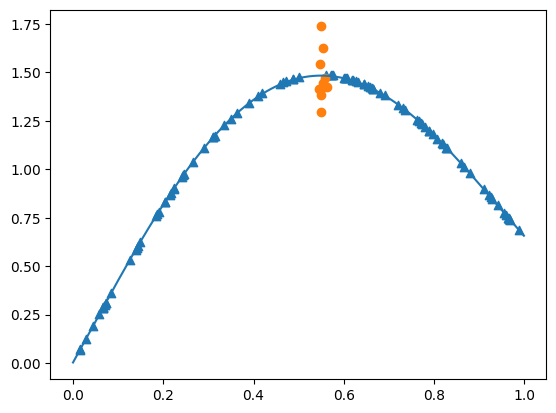

Best Result: x=0.550, y=1.738
PRIOR = <function prior_1 at 0x0000022BD72154E0>	FUNCTION = <function multimodal_1 at 0x0000022B9ECE6160>
minimo: 1.6524387132579816 +- 0.003453200254903917
--------------------------------------------------------------------------------------------------------------------------------





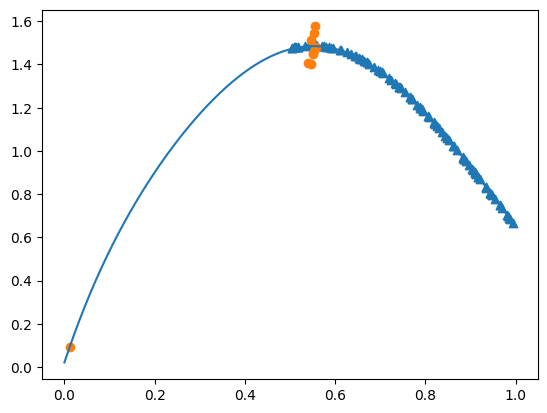

Best Result: x=0.555, y=1.576
PRIOR = <function prior_2 at 0x0000022BD7215580>	FUNCTION = <function multimodal_1 at 0x0000022B9ECE6160>
minimo: 1.6331201082906082 +- 0.0030684697617496424
--------------------------------------------------------------------------------------------------------------------------------





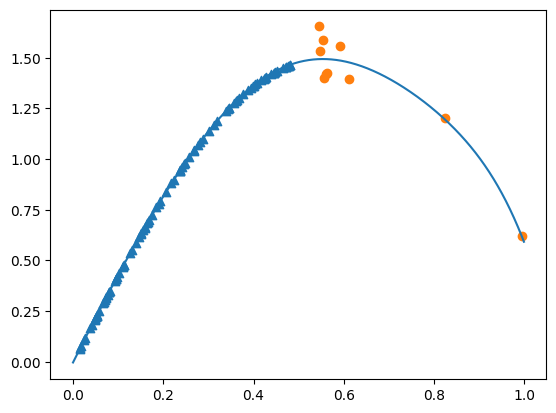

Best Result: x=0.544, y=1.654
PRIOR = <function prior_3 at 0x0000022BD7215300>	FUNCTION = <function multimodal_1 at 0x0000022B9ECE6160>
minimo: 1.6196982275849736 +- 0.003107222271773716
--------------------------------------------------------------------------------------------------------------------------------





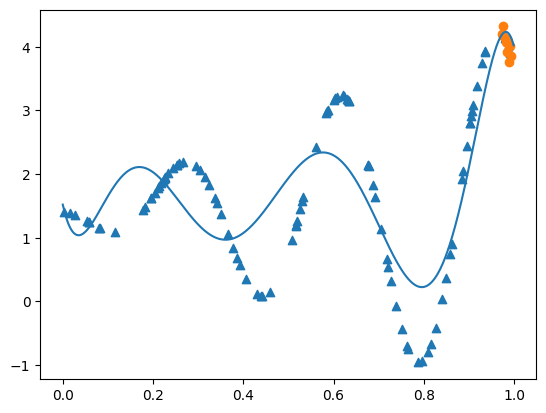

Best Result: x=0.976, y=4.319
PRIOR = <function prior_1 at 0x0000022BD72154E0>	FUNCTION = <function multimodal_2 at 0x0000022B9BD63CE0>
minimo: 4.306795977639131 +- 0.002662365101103139
--------------------------------------------------------------------------------------------------------------------------------





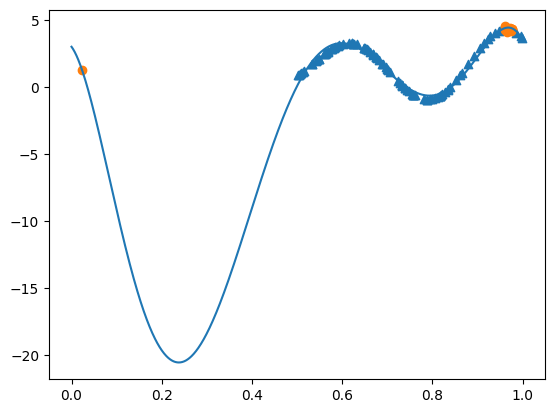

Best Result: x=0.961, y=4.496
PRIOR = <function prior_2 at 0x0000022BD7215580>	FUNCTION = <function multimodal_2 at 0x0000022B9BD63CE0>
minimo: 4.4276732151227955 +- 0.004450930328723133
--------------------------------------------------------------------------------------------------------------------------------





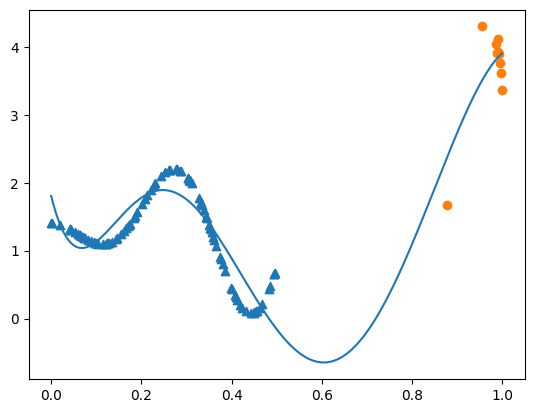

Best Result: x=0.956, y=4.299
PRIOR = <function prior_3 at 0x0000022BD7215300>	FUNCTION = <function multimodal_2 at 0x0000022B9BD63CE0>
minimo: 4.212379427844025 +- 0.01236278151609455
--------------------------------------------------------------------------------------------------------------------------------





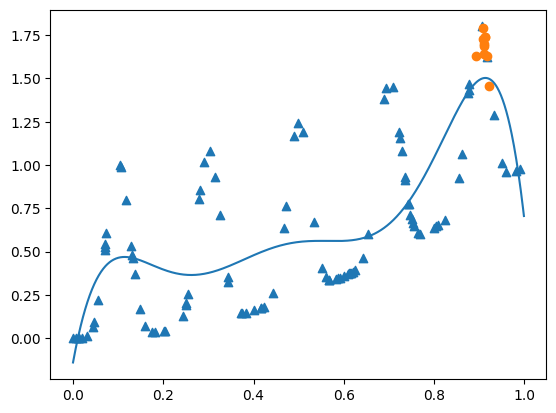

Best Result: x=0.905, y=1.800
PRIOR = <function prior_1 at 0x0000022BD72154E0>	FUNCTION = <function multimodal_3 at 0x0000022BD74E8220>
minimo: 1.8414890774269872 +- 0.007604525038058962
--------------------------------------------------------------------------------------------------------------------------------





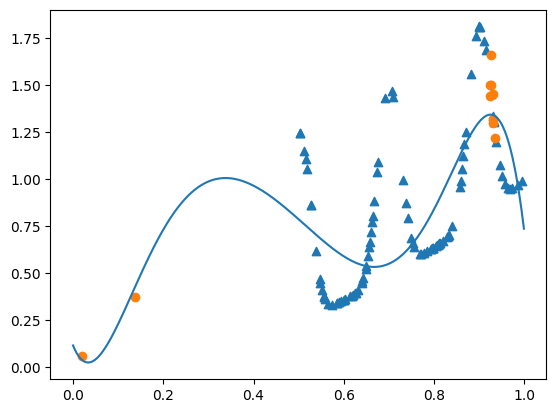

Best Result: x=0.900, y=1.810
PRIOR = <function prior_2 at 0x0000022BD7215580>	FUNCTION = <function multimodal_3 at 0x0000022BD74E8220>
minimo: 1.8326261894580902 +- 0.0023709792588644664
--------------------------------------------------------------------------------------------------------------------------------





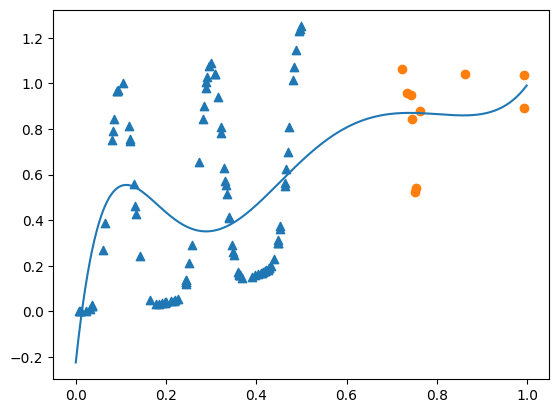

Best Result: x=0.500, y=1.249
PRIOR = <function prior_3 at 0x0000022BD7215300>	FUNCTION = <function multimodal_3 at 0x0000022BD74E8220>
minimo: 1.6423874386912631 +- 0.05928693431081888
--------------------------------------------------------------------------------------------------------------------------------





In [33]:

size = 100
priors = [prior_1, prior_2, prior_3]
functions = [multimodal_1, multimodal_2, multimodal_3]

for f in functions:
    for prior in priors:
        min_list = []

        for sssss in range(100):
            X, y, model = bayesianOptmization(10, size, UCB, f, prior=prior) #TODO try with other priors, acquisition functions and objective func
            ix = argmax(y)
                
            if sssss == 0:
                plot(X, y, model, size)
                # best result
                print('Best Result: x=%.3f, y=%.3f' % (X[ix][0], y[ix][0]))

            min_list.append(y[ix][0])

        media = sum(min_list) / len(min_list)
        varianza = sum((x - media) ** 2 for x in min_list) / len(min_list)
        print(f'PRIOR = {prior}\tFUNCTION = {f}')
        print(f'minimo: {media} +- {varianza}' )
        print('--------------------------------------------------------------------------------------------------------------------------------\n\n\n')
                
        





c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

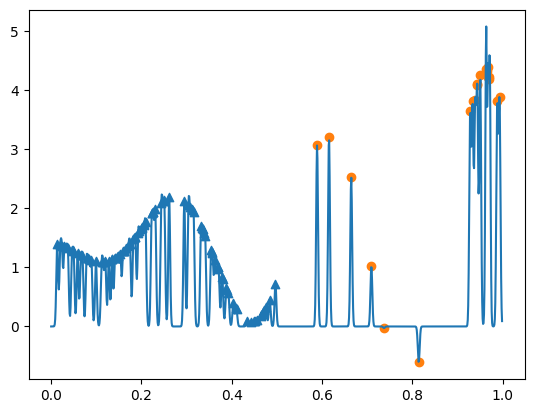

Best Result: x=0.968, y=4.392


c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

KERNEL = RBF(length_scale=0.7)
minimo: 3.507725740815283 +- 0.9450401676712505
--------------------------------------------------------------------------------------------------------------------------------





c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\ca

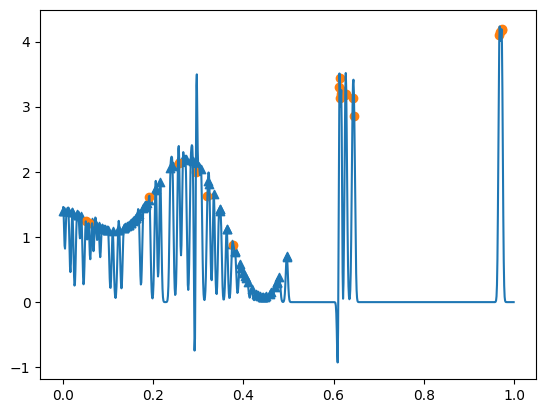

Best Result: x=0.972, y=4.190


c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

KERNEL = ExpSineSquared(length_scale=1, periodicity=1)
minimo: 4.085172324106156 +- 0.15739266680881067
--------------------------------------------------------------------------------------------------------------------------------





c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again

In [34]:
size = 100
kernel_rbf = RBF(length_scale = 0.7)
kernel_expsin = ExpSineSquared(length_scale = 1)

kernels = [kernel_rbf, kernel_expsin]

for kernel in kernels:
    min_list = []

    for sssss in range(10):
        X, y, model = bayesianOptmization(20, size, EI, multimodal_2, prior_3, kernel=kernel) #TODO try with other priors, acquisition functions and objective func
        ix = argmax(y)
        
        if sssss == 0:
            plot(X, y, model, size)
            # best result
            print('Best Result: x=%.3f, y=%.3f' % (X[ix][0], y[ix][0]))

        min_list.append(y[ix][0])

    media = sum(min_list) / len(min_list)
    varianza = sum((x - media) ** 2 for x in min_list) / len(min_list)
    print(f'KERNEL = {kernel}')
    print(f'minimo: {media} +- {varianza}' )
    print('--------------------------------------------------------------------------------------------------------------------------------\n\n\n')
                
        

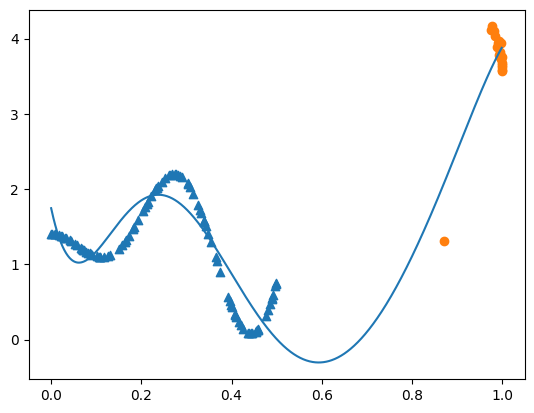

Best Result: x=0.977, y=4.161
KERNEL = None	ACQUISITION = <function UCB at 0x0000022BD427CAE0>
minimo: 4.309922073873962 +- 0.009349228114894472
--------------------------------------------------------------------------------------------------------------------------------





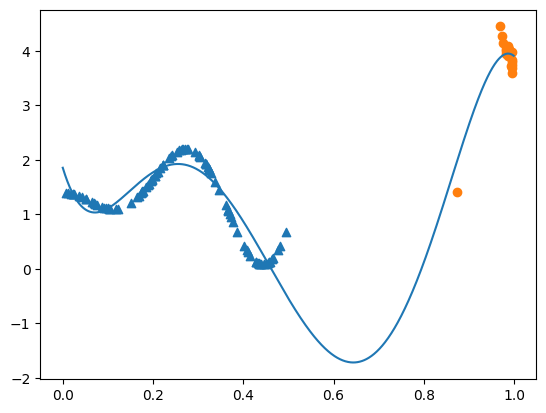

Best Result: x=0.969, y=4.445
KERNEL = None	ACQUISITION = <function LCB at 0x0000022BCFE6C400>
minimo: 4.2948188441589 +- 0.007823237162019351
--------------------------------------------------------------------------------------------------------------------------------





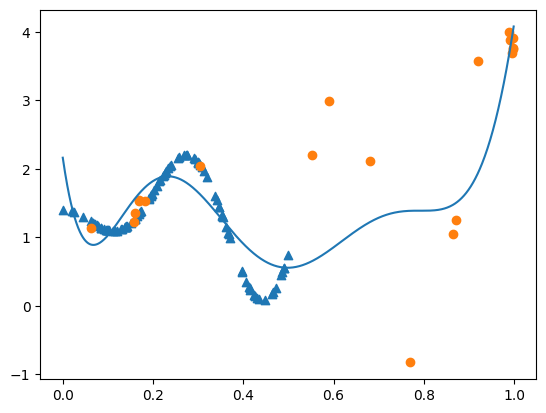

Best Result: x=0.988, y=4.005
KERNEL = None	ACQUISITION = <function EI at 0x0000022BCEA4F740>
minimo: 4.092369336410277 +- 0.03879406544176306
--------------------------------------------------------------------------------------------------------------------------------





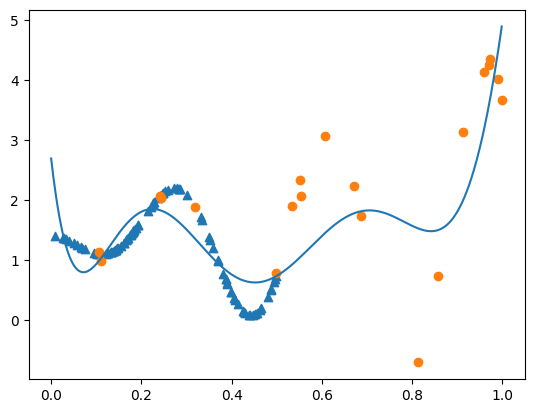

Best Result: x=0.972, y=4.347
KERNEL = None	ACQUISITION = <function PI at 0x0000022BCFE6F4C0>
minimo: 4.0423451406360735 +- 0.162691368088371
--------------------------------------------------------------------------------------------------------------------------------





In [40]:
size = 100
kernel_rbf = RBF(length_scale = 0.7)
acquisitions = [UCB, LCB, EI, PI]
kernels = [None]

for acq in acquisitions:
    for kernel in kernels:
        min_list = []

        for sssss in range(100):
            X, y, model = bayesianOptmization(20, size, acq, multimodal_2, prior_3, kernel=kernel) #TODO try with other priors, acquisition functions and objective func
            ix = argmax(y)
                
            if sssss == 0:
                plot(X, y, model, size)
                # best result
                print('Best Result: x=%.3f, y=%.3f' % (X[ix][0], y[ix][0]))

            min_list.append(y[ix][0])

        media = sum(min_list) / len(min_list)
        varianza = sum((x - media) ** 2 for x in min_list) / len(min_list)
        print(f'KERNEL = {kernel}\tACQUISITION = {acq}')
        print(f'minimo: {media} +- {varianza}' )
        print('--------------------------------------------------------------------------------------------------------------------------------\n\n\n')
                
        




### BONUS

You can now change the acquisition functions in the regression problem, adding a slack variable `k` as a hyperparameter. How does this variable affect the optimization problem?

k grande da più  peso alla varianza -> è più in grado a generaliizzare 

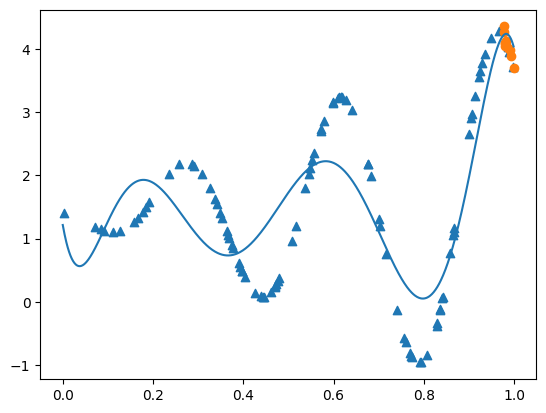

Best Result: x=0.977, y=4.355
KERNEL = None	K = 0
minimo: 4.301087615626477 +- 0.004116813736924362
--------------------------------------------------------------------------------------------------------------------------------





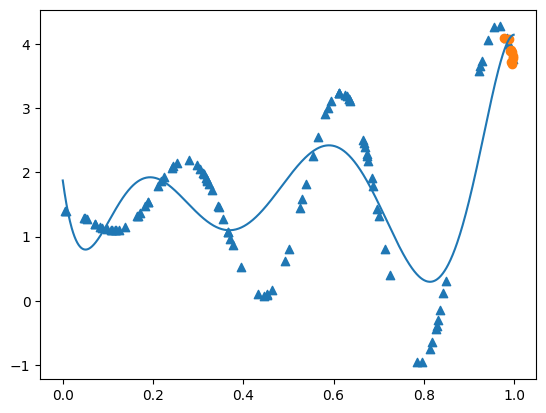

Best Result: x=0.969, y=4.268
KERNEL = None	K = 0.1
minimo: 4.294388923455363 +- 0.0021928362412556774
--------------------------------------------------------------------------------------------------------------------------------





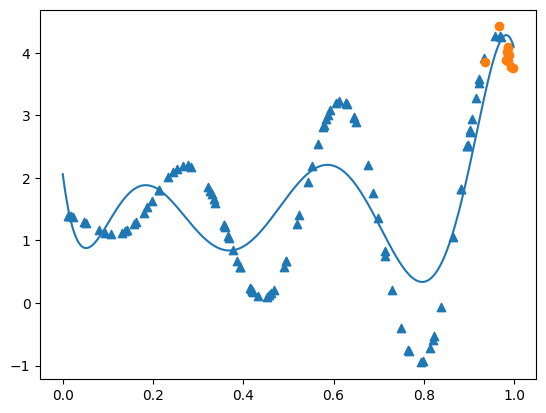

Best Result: x=0.967, y=4.421
KERNEL = None	K = 0.3
minimo: 4.302364127042897 +- 0.004394831348696439
--------------------------------------------------------------------------------------------------------------------------------





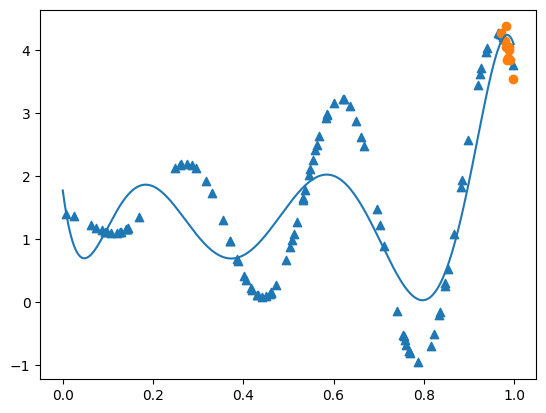

Best Result: x=0.981, y=4.379
KERNEL = None	K = 0.5
minimo: 4.308170296671551 +- 0.003236435467194971
--------------------------------------------------------------------------------------------------------------------------------





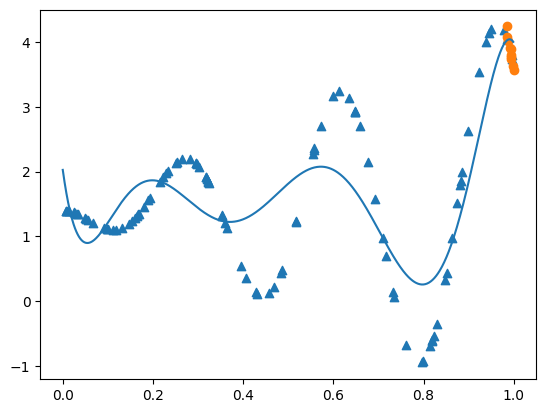

Best Result: x=0.985, y=4.240
KERNEL = None	K = 1
minimo: 4.306951996747593 +- 0.002471504724337937
--------------------------------------------------------------------------------------------------------------------------------





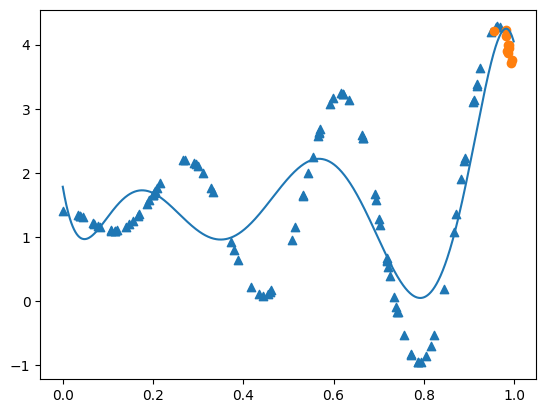

Best Result: x=0.962, y=4.283
KERNEL = None	K = 1.5
minimo: 4.309547115671412 +- 0.004198727742918813
--------------------------------------------------------------------------------------------------------------------------------





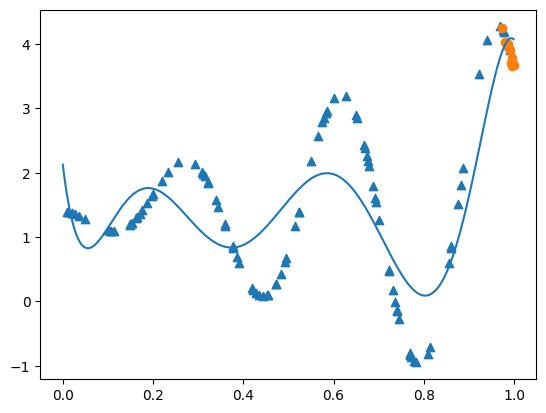

Best Result: x=0.968, y=4.274
KERNEL = None	K = 4
minimo: 4.299654923264674 +- 0.0020647070171517026
--------------------------------------------------------------------------------------------------------------------------------





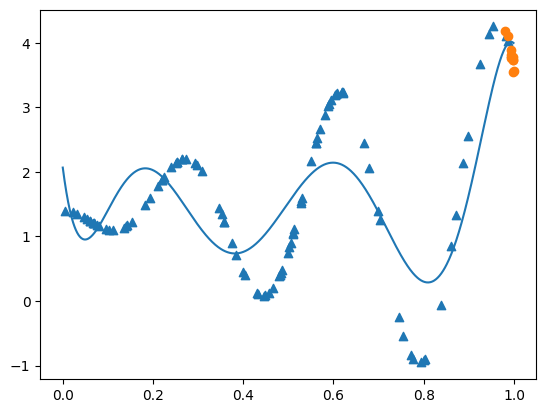

Best Result: x=0.955, y=4.251
KERNEL = None	K = 15
minimo: 4.302925347147347 +- 0.003836481416462141
--------------------------------------------------------------------------------------------------------------------------------





In [45]:
size = 100
k_list = [0, 0.1, 0.3, 0.5, 1, 1.5, 4, 15]

for k in k_list:
    min_list = []

    for sssss in range(100):
        X, y, model = bayesianOptmization(10, size, LCB, multimodal_2, prior_1, k = k, kernel=None) #TODO try with other priors, acquisition functions and objective func
        ix = argmax(y)
            
        if sssss == 0:
            plot(X, y, model, size)
            # best result
            print('Best Result: x=%.3f, y=%.3f' % (X[ix][0], y[ix][0]))

        min_list.append(y[ix][0])

    media = sum(min_list) / len(min_list)
    varianza = sum((x - media) ** 2 for x in min_list) / len(min_list)
    print(f'KERNEL = {kernel}\tK = {k}')
    print(f'minimo: {media} +- {varianza}' )
    print('--------------------------------------------------------------------------------------------------------------------------------\n\n\n')
                